In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install 'shimmy>=0.2.1'
!pip install git+https://github.com/DLR-RM/stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 29.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-texonpqb
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-texonpqb
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit fd0cd82339511b54cd3907df228a656f2a32f0b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for stable-baselines3: filename=stable_baselines3-2.0.0a8-py3-none-any.whl size=177948 sha256=e58bb260800a06c71ebbf21256b4f43ef5505bd09f0841b0519aafaa554044ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-k5bkul2b/wheels/3b/24/65/bc2794face336930a7

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torch
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DDPG
import ast

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


# 0. Load data

In [4]:
# set directory
ROOT_PATH = '/content/drive/MyDrive/MBAn/Sensorimotor/project'
directory = ROOT_PATH + '/data/'
model_dir = ROOT_PATH + '/model/'

# set global variable TOKENS used in all environments
TOKENS = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP']

In [5]:
df_close = pd.read_csv(directory+'df_close.csv')
df_close.open_time_ms = pd.to_datetime(df_close['open_time_ms'])
df_close.head()

,open_time_ms,ADA_close,ATOM_close,AVAX_close,BNB_close,BTC_close,DOGE_close,DOT_close,ETH_close,LINK_close,LTC_close,MATIC_close,SHIB_close,SOL_close,TRX_close,UNI_close,XRP_close,USD_close
0,2022-01-01 00:00:00,1.314,32.81,109.98,512.9,46321.34,0.1705,26.75,3690.09,19.57,146.4,2.541,0.000033,170.40,0.07552,17.08,0.8334,1.0
1,2022-01-01 00:05:00,1.316,32.58,110.06,513.3,46371.11,0.1703,26.80,3696.55,19.58,146.6,2.545,0.000033,170.60,0.07538,17.09,0.8330,1.0
2,2022-01-01 00:10:00,1.317,32.46,110.07,513.5,46332.51,0.1705,26.84,3691.90,19.60,146.7,2.546,0.000033,170.85,0.07538,17.11,0.8322,1.0
3,2022-01-01 00:15:00,1.317,32.47,109.95,513.5,46293.90,0.1703,26.77,3689.51,19.57,146.6,2.536,0.000033,171.07,0.07531,17.08,0.8319,1.0
4,2022-01-01 00:20:00,1.322,32.77,110.61,514.3,46395.53,0.1709,26.95,3699.45,19.64,147.0,2.548,0.000034,171.20,0.07553,17.10,0.8349,1.0


In [6]:
df_volume = pd.read_csv(directory+'df_volume.csv')
df_volume.open_time_ms = pd.to_datetime(df_volume['open_time_ms'])
df_volume.head()

,open_time_ms,ADA_volume,ATOM_volume,AVAX_volume,BNB_volume,BTC_volume,DOGE_volume,DOT_volume,ETH_volume,LINK_volume,LTC_volume,MATIC_volume,SHIB_volume,SOL_volume,TRX_volume,UNI_volume,XRP_volume,USD_volume
0,2022-01-01 00:00:00,1209224.3,54621.76,8587.78,2352.644,185.67558,2519628.0,24592.11,1363.4570,33197.32,2050.067,449849.2,2.162479e+10,4329.30,3076457.5,6739.54,945000.0,0.0
1,2022-01-01 00:05:00,298386.5,28489.13,7392.95,1688.173,123.43577,1783685.0,17049.93,862.5494,13470.81,655.730,203782.8,1.347277e+10,2212.70,2180233.5,4115.82,468801.0,0.0
2,2022-01-01 00:10:00,389329.2,20890.84,5129.06,1023.833,77.54574,1428416.0,12995.91,753.5524,10046.50,544.532,181298.2,1.042813e+10,3310.82,1649554.4,7447.60,631674.0,0.0
3,2022-01-01 00:15:00,221077.2,9810.92,7974.74,1377.344,101.14315,1148033.0,9857.93,438.4134,7221.73,416.076,141379.4,2.456715e+10,2917.19,1038627.4,10391.02,346621.0,0.0
4,2022-01-01 00:20:00,189448.2,7518.41,4352.98,1304.058,135.32479,894261.0,33604.41,372.5966,6060.02,971.667,153877.3,6.909299e+09,2954.40,909110.0,4209.92,546138.0,0.0


In [7]:
timeline = df_volume.open_time_ms
btc_benchmark = df_close.BTC_close
eth_benchmark = df_close.ETH_close

# 1. Baselines

## Randomization

In [8]:
px = df_close.iloc[:,1:-1].values
ret = (px[1:] - px[:-1])/px[:-1]
ret12 = (px[12:] - px[:-12])/px[:-12]

In [37]:
def get_asset_history(weights, ret, start = 10000):
    port_value = [start]
    lag = 1
    for i in range(len(weights)-lag):
        current = port_value[-1] * (ret[i+lag] * weights[i]).sum()
        port_value.append(port_value[-1] + current)
    return np.array(port_value)

In [38]:
np.random.seed(45)

w_rand = np.random.rand(ret.shape[0],ret.shape[1])
w_rand = (w_rand.T - w_rand.mean(axis=1).T).T
w_rand_sum = np.abs(w_rand).sum(axis=1)
w_rand = (w_rand.T / w_rand_sum.T).T

In [39]:
rand_port_value = get_asset_history(w_rand, ret)

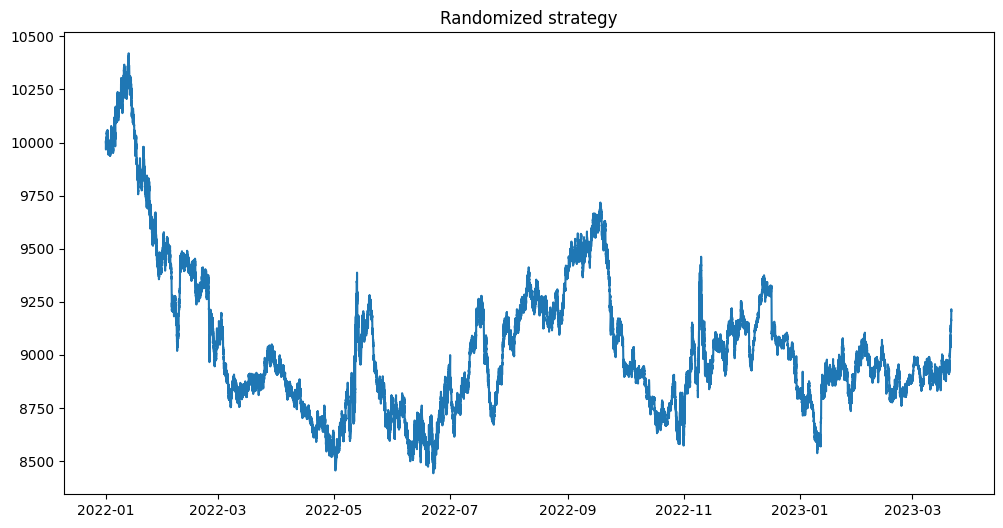

In [40]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(timeline[1:], rand_port_value);
ax.set_title('Randomized strategy');

## Mean reversion strategy

$$
\begin{aligned}
  Return_{market}^t &= \frac{1}{n} \sum^n_i Return_{i}^t \\
  weight_{i}^{t} &= \frac{Return_{market}^t - Return_i^t}{\sum^n_i |Return_{market}^i - Return_i^t|}
\end{aligned}
$$

In [41]:
eps = 1e-10
ret_m = ret.mean(axis=1)
mc_w = np.zeros_like(ret)
for i in range(ret.shape[0]):
    mc_w[i] = ret_m[i] - ret[i]
    mc_w[i] = mc_w[i] / np.abs(mc_w[i]).sum()

In [42]:
mc_port_value = get_asset_history(mc_w, ret)

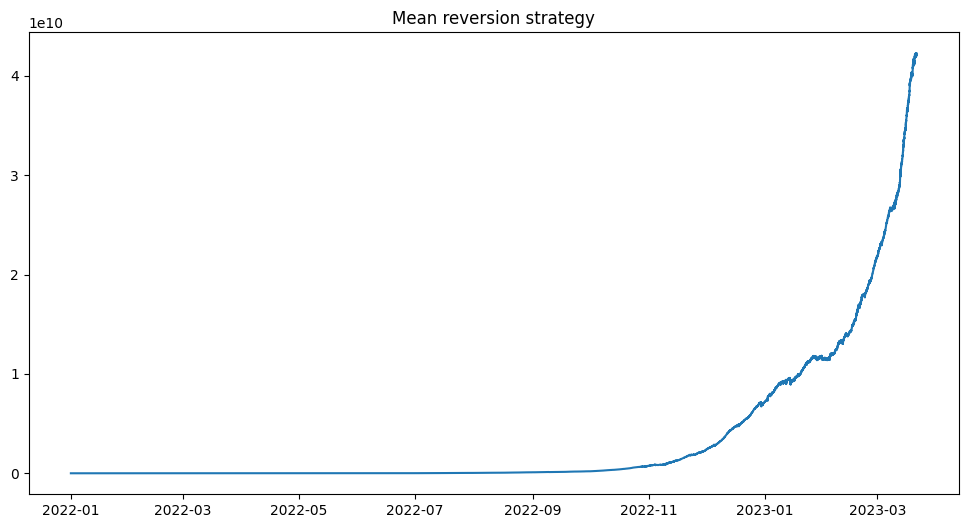

In [43]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(timeline[1:], mc_port_value);
ax.set_title('Mean reversion strategy');

## Momentum strategy

$$
\begin{aligned}
  Return_{market}^t &= \frac{1}{n} \sum^n_i Return_{i}^t \\
  weight_{i}^{t+1} &= \frac{Return_i^t - Return_{market}^t}{\sum^n_i |Return_{market}^i - Return_i^t|}
\end{aligned}
$$

In [44]:
eps = 1e-10
ret_m = ret.mean(axis=1)
mm_w = np.zeros_like(ret)
for i in range(ret.shape[0]):
    mm_w[i] = ret[i] - ret_m[i]
    mm_w[i] = mm_w[i] / np.abs(mm_w[i]).sum()

In [45]:
mm_port_value = get_asset_history(mm_w, ret)

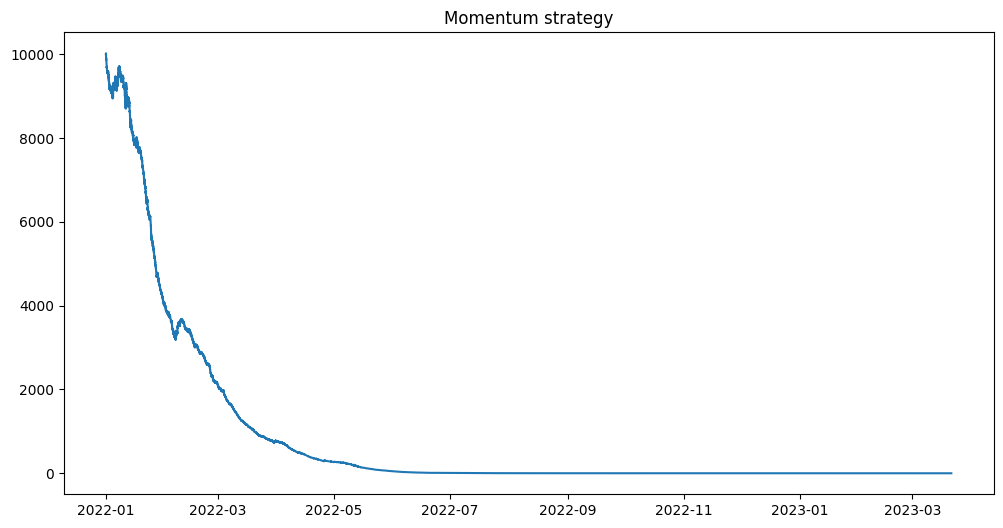

In [46]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(timeline[1:], mm_port_value);
ax.set_title('Momentum strategy');

In [71]:
corr = np.zeros([16,16])

for i in range(16):
    for j in range(16):
        corr[i,j] = np.corrcoef(ret[1:,i],ret[:-1,j])[1,0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
corr_df = pd.DataFrame(corr, index = TOKENS, columns = TOKENS)
corr_df

,ADA,ATOM,AVAX,BNB,BTC,DOGE,DOT,ETH,LINK,LTC,MATIC,SHIB,SOL,TRX,UNI,XRP
ADA,-0.018760,0.004246,0.001978,-0.012493,-0.012107,-0.000715,0.000743,-0.009210,-0.003810,-0.004096,-0.006079,0.002773,-0.002346,0.003305,-0.005023,-0.005438
ATOM,-0.006718,-0.011673,-0.003013,-0.012959,-0.014763,-0.005971,-0.008515,-0.009551,-0.005521,-0.006836,-0.011253,-0.003254,-0.008970,-0.006401,-0.006970,-0.015409
AVAX,-0.004972,0.008553,-0.022196,-0.011893,-0.010107,-0.000009,-0.002575,-0.005525,-0.001982,-0.006647,-0.009267,0.004276,-0.002349,0.001845,-0.005314,-0.011274
BNB,0.001812,0.008752,0.007411,-0.011135,-0.001577,0.002498,0.005696,0.000831,0.005231,-0.000460,0.000579,0.006204,0.003466,0.011012,-0.001186,-0.003303
BTC,-0.006905,-0.001989,-0.003414,-0.013493,-0.022586,-0.009005,-0.001882,-0.015902,-0.006334,-0.008571,-0.011709,-0.008843,-0.006615,0.003004,-0.007652,-0.012011
DOGE,-0.004717,0.005557,0.000785,-0.011450,-0.011801,-0.022009,0.000555,-0.006987,-0.002398,-0.007253,-0.007217,0.005710,-0.004553,0.007554,-0.008280,-0.011219
DOT,-0.007502,0.005474,-0.004238,-0.011771,-0.011812,-0.005496,-0.042613,-0.007414,-0.005047,-0.008554,-0.009775,-0.002027,-0.005388,-0.003810,-0.007934,-0.012955
ETH,0.002797,0.008144,0.007103,-0.005278,-0.006536,0.000802,0.006964,-0.010522,0.003054,0.000817,-0.000395,0.002679,0.005924,0.008163,-0.000203,-0.005227
LINK,-0.002754,0.005971,0.001240,-0.009632,-0.010691,-0.002813,-0.001339,-0.006430,-0.017666,-0.004023,-0.005550,0.000594,-0.007090,0.003443,-0.004424,-0.008139
LTC,0.000566,0.005757,0.006555,-0.008969,-0.004565,0.001729,0.003703,-0.001595,-0.001074,-0.021252,-0.003930,0.003935,0.005407,0.004889,-0.003018,-0.007946


# 2. Long & short, technicals in state space

## Environment
- added shorting (half in long and half in short, p&l each period = weights * % change in price)
- removed USD as if the strategy is market neural we should be able to fully deploy at all times (starting with 0 weights in all)
- added randomize start time: idea is that we pick a random point in time to start, we run for `total_time` steps. Allows for more episodes and might encourage data diversity.

In [47]:
class LongShortEnv(gym.Env):

    def __init__(self,
                 full_data,
                 initial_amount=10000,
                 total_time = 10000,
                 rand_start_time = True,
                 mode='train'
                 ):
        
        self.full_data = full_data
        self.full_len = self.full_data.shape[0]

        global TOKENS
        self.tokens = TOKENS

        self.time = 0
        self.total_time = min(self.full_len, total_time)
        self.time_stamp_memory = [self.time]

        # randomize starting point
        self.start_time = 0
        self.rand_start_time = rand_start_time
        if self.rand_start_time:
            if self.total_time < self.full_len:
                self.start_time = np.random.randint(0, self.full_len - self.total_time - 1)

        self.data = self.full_data[self.start_time + self.time]
        self.stock_dim = full_data.shape[1]
        self.initial_amount = initial_amount

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.stock_dim,))
        self.state_dim = full_data.shape[2]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.stock_dim, self.state_dim))

        self.state = self.data
        self.terminal = False
        self.portfolio_value = self.initial_amount
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory = [[0] * self.stock_dim]
        
        self.current_episode = 0
        self.mode = mode

    def step(self, actions):
        self.terminal = self.time >= self.total_time-1
        
        if self.terminal:
            if self.mode == 'train':
                cumulative_return = (self.portfolio_value / self.initial_amount) - 1
                print(f"Episode: {self.current_episode} | Timesteps: {self.time + 1} | Cumulative Return: {cumulative_return:.2%}")
            else:
                print('Done')
            self.current_episode += 1
            return self.state, self.reward, self.terminal, {}

        else:
            actions = torch.tensor(actions)
            weights = self.longshort(actions)
            self.actions_memory.append(weights.numpy())
            last_time_memory = self.data

            self.time += 1
            self.data = self.full_data[self.start_time + self.time]
            self.state = self.data

            portfolio_return = torch.sum(((self.data[:,0] / last_time_memory[:,0]) - 1) * weights)
            new_portfolio_value = self.portfolio_value * (1 + portfolio_return)
            self.portfolio_value = new_portfolio_value

            self.portfolio_return_memory.append(portfolio_return.item())
            self.asset_memory.append(new_portfolio_value.item())
            self.reward = portfolio_return 

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.time = 0

        # randomize starting point
        self.start_time = 0
        if self.rand_start_time:
            if self.total_time < self.full_len:
                self.start_time = np.random.randint(0, self.full_len - self.total_time - 1)

        self.data = self.full_data[self.start_time + self.time]
        self.state = self.data
        self.portfolio_value = self.initial_amount
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory = [[0] * self.stock_dim]
        self.time_stamp_memory = [self.time]
        return self.state
        
    def longshort(self, actions):
        eps = 1e-10
        if not isinstance(actions, torch.Tensor):
            actions = torch.tensor(actions)
        actions = actions - actions.mean()
        if actions.abs().sum() < eps:
            actions = actions / (actions.abs().sum()+eps)
        else:
            actions = actions / actions.abs().sum()
        return actions

    def save_asset_memory(self):
        return self.asset_memory

    def save_action_memory(self):
        date_list = self.time_stamp_memory
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.tokens
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## State space

0. current price (normalize all cryptos)
1. 12 period EMA
2. Moving Average Convergence Divergence (MACD): EMA(26) - EMA(12)
3. 1 period returns
4. 2 period cumulative returns
5. 6 period cumulative returns
6. 12 period cumulative returns
7. 24 period cumulative returns
8. 1 period returns relative to market
9. 2 period cumulative returns relative to market
10. 6 period cumulative returns relative to market
11. 12 period cumulative returns relative to market
12. 24 period cumulative returns relative to market
13. 14 period RSI
14. 14 period RSI relative to market
15. 12 period volatility (stdev)
16. 24 period volatility (stdev)
17. 1 period volume (normalized)
18. 2 period volume
19. 6 period volume
20. 12 period volume
21. 24 period volume


In [48]:
# MACD uses 26 periods so we start index from 25 onwards
start_idx = 25
n_peirods_total = len(df_close)-start_idx

In [49]:
# state space shape: 16 cyrpto currencies (market neural so don't need cash), 22 features each
data = torch.zeros([n_peirods_total,16,22])

In [50]:
# 0. current price, normalize all by dividing by the first datapoint
px = df_close.iloc[:,1:-1].values
px = px / px[0]
data[:,:,0] = torch.tensor(px[start_idx:])

In [51]:
# 1. 12 period EMA

def ema(prices, n):
    smoothing_factor = 2 / (n + 1)
    ema_values = np.zeros_like(prices)
    ema_values[0,:] = prices[0,:]
    for i in range(1, prices.shape[0]):
        ema_values[i,:] = (prices[i,:] * smoothing_factor) + (ema_values[i-1,:] * (1 - smoothing_factor))
    return ema_values

ema_12 = ema(px,12)
data[:,:,1] = torch.tensor(ema_12[start_idx:])

In [52]:
# 2. MACD

macd = ema(px,26) - ema_12
data[:,:,2] = torch.tensor(macd[start_idx:])

In [53]:
# 3-7. 1,2,6,12,24 period returns

per = [1,2,6,12,24]

for i,t in enumerate(per):
    ret = (px[t:] - px[:-t]) / px[:-t]
    data[:,:,i+3] = torch.tensor(ret[ret.shape[0] - n_peirods_total:])

In [54]:
# 8-12. 1,2,6,12,24 period returns relative to market

data[:,:,8:13] = data[:,:,3:8] - data[:,:,3:8].mean(dim=0)

In [55]:
# 13-14. 14 period RSI / relative to market

def rsi(prices, n=14):
    deltas = prices[1:] - prices[:-1]
    seed = deltas[:n+1]
    up = (seed * (seed >= 0)).sum(axis=0) / n
    down = (-seed * (seed < 0)).sum(axis=0) / n
    rs = up / down
    rsi = np.zeros([prices.shape[0]-n,prices.shape[1]])
    rsi[0] = 1 - 1 / (1 + rs)

    for i in range(n+1, prices.shape[0]):
        delta = deltas[i-1]  # the delta for the current price
        up = (up * (n - 1) + (delta * (delta>=0))) / n
        down = (down * (n - 1) + (-delta* (delta<0))) / n
        rs = up / down
        rsi[i-n] = 1 - 1 / (1 + rs)

    return rsi

rsi_14 = rsi(px)
data[:,:,13] = torch.tensor(rsi_14[rsi_14.shape[0] - n_peirods_total:])

data[:,:,14] = data[:,:,13] - data[:,:,13].mean(dim=0)

In [56]:
# 15-16. vol 12 & 24

def rolling_vol(prices, n):
    vol = np.zeros_like(prices)
    for i in range(n,prices.shape[0]):
        vol[i] = prices[i-n:i].std(axis=0)
    return vol

vol_12 = rolling_vol(px,12)
data[:,:,15] = torch.tensor(vol_12[start_idx:])

vol_24 = rolling_vol(px,24)
data[:,:,16] = torch.tensor(vol_24[start_idx:])

In [57]:
# 17. 1 period volume

volume = df_volume.iloc[:,1:-1].values

# Normalize volume by average in the first 26 periods
# This is kind of arbitrary but thought it might run better with all the numbers close to 1
volume = volume / volume[0:26].mean(axis=0)

data[:,:,17] = torch.tensor(volume[start_idx:])

In [58]:
# 18-21. 2,6,12,24 period volume

def sum_volume(volume, n):
    volume = np.zeros_like(volume)
    for i in range(n,volume.shape[0]):
        volume[i] = volume[i-n:i].sum(axis=0)
    return volume

per = [2,6,12,24]

for i,t in enumerate(per):
    vol_sum = sum_volume(volume,t)
    data[:,:,18+i] = torch.tensor(vol_sum[start_idx:])

### Separate train val test

In [59]:
val_idx = int(n_peirods_total*0.7)
test_idx = int(n_peirods_total*0.85)

train_data = data[:val_idx]
val_data = data[val_idx:test_idx]
test_data = data[test_idx]

## Agents

In [60]:
df_inSample = pd.DataFrame({'time':timeline[start_idx:val_idx+start_idx]})
df_val = pd.DataFrame({'time':timeline[val_idx+start_idx:test_idx+start_idx]})

### A2C

In [61]:
ls_train_gym = LongShortEnv(full_data = train_data)

#### A2C - Train

In [67]:
a2c_model = A2C("MlpPolicy", ls_train_gym, verbose=0, gamma=0.5)
a2c_model.learn(total_timesteps=300000)
a2c_model.save(model_dir + "A2C_lowGamma_v2")

KeyboardInterrupt: ignored

In [62]:
a2c_model = A2C.load(model_dir + "A2C_lowGamma_v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### A2C - in sample performance

In [63]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = a2c_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

df_inSample['A2C'] = port_size

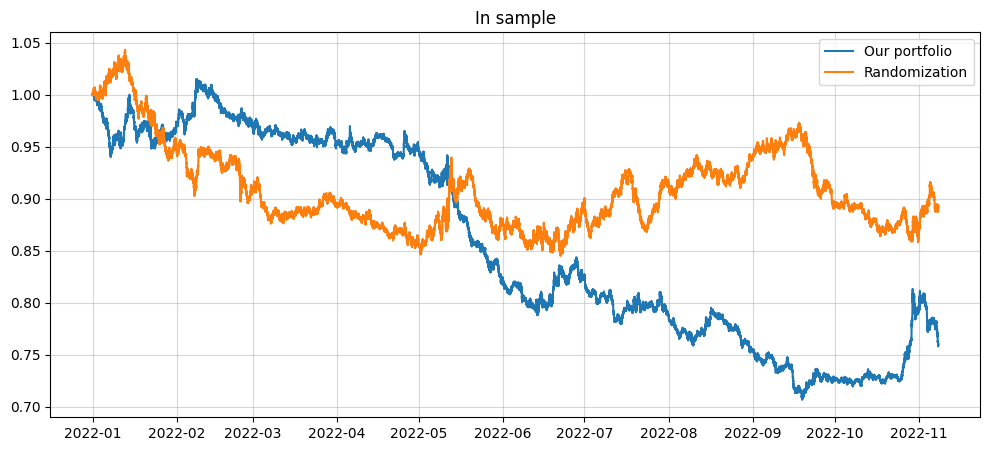

In [65]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(timeline[start_idx:val_idx+start_idx], 
        np.array(port_size)/10000, label='Our portfolio')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        rand_port_value[start_idx:val_idx+start_idx] / rand_port_value[start_idx], label='Baseline')
ax.set_title('In sample')
ax.grid(alpha=0.5)
ax.legend();

#### A2C - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

df_val['A2C'] = val_port_size

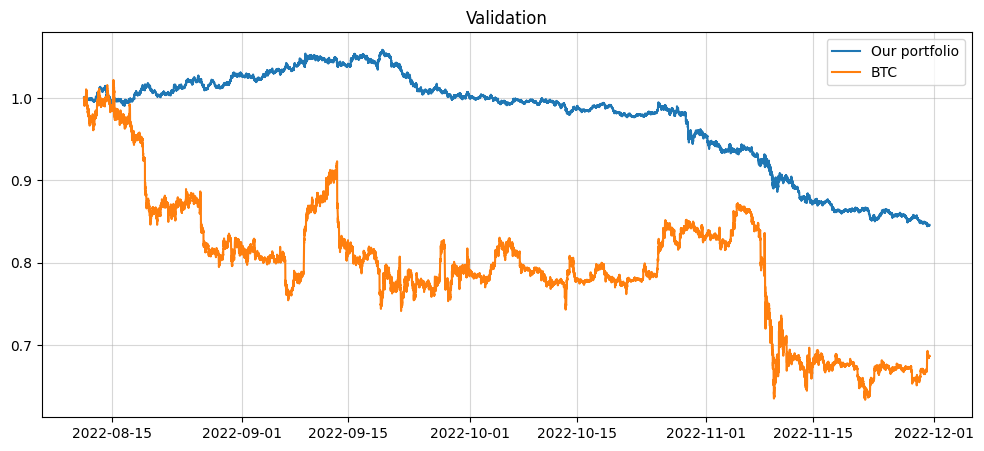

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        np.array(val_port_size)/10000, label='Our portfolio')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        btc_benchmark[val_idx+start_idx:test_idx+start_idx] / btc_benchmark[val_idx+start_idx], label='BTC')
ax.set_title('Validation')
ax.grid(alpha=0.5)
ax.legend();

### PPO

#### PPO - Train

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

In [ ]:
ppo_model = PPO("MlpPolicy", ls_train_gym, verbose=0, gamma=0.1)
ppo_model.learn(total_timesteps=300000)
ppo_model.save(model_dir + "PPO_lowGamma_v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Episode: 0 | Timesteps: 10000 | Cumulative Return: -3.57%
Episode: 1 | Timesteps: 10000 | Cumulative Return: -0.21%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -2.01%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -11.31%
Episode: 4 | Timesteps: 10000 | Cumulative Return: 3.35%
Episode: 5 | Timesteps: 10000 | Cumulative Return: -3.31%
Episode: 6 | Timesteps: 10000 | Cumulative Return: 4.08%
Episode: 7 | Timesteps: 10000 | Cumulative Return: 11.81%
Episode: 8 | Timesteps: 10000 | Cumulative Return: 1.76%
Episode: 9 | Timesteps: 10000 | Cumulative Return: -5.69%
Episode: 10 | Timesteps: 10000 | Cumulative Return: 4.82%
Episode: 11 | Timesteps: 10000 | Cumulative Return: 3.69%
Episode: 12 | Timesteps: 10000 | Cumulative Return: 4.25%
Episode: 13 | Timesteps: 10000 | Cumulative Return: 3.75%
Episode: 14 | Timesteps: 10000 | Cumulative Return: 3.96%
Episode: 15 | Timesteps: 10000 | Cumulative Return: -3.21%
Episode: 16 | Timesteps: 10000 | Cumulative Return: 2.48%
Episode: 17 | T

#### PPO - in sample

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

In [ ]:
df_inSample['PPO'] = port_size

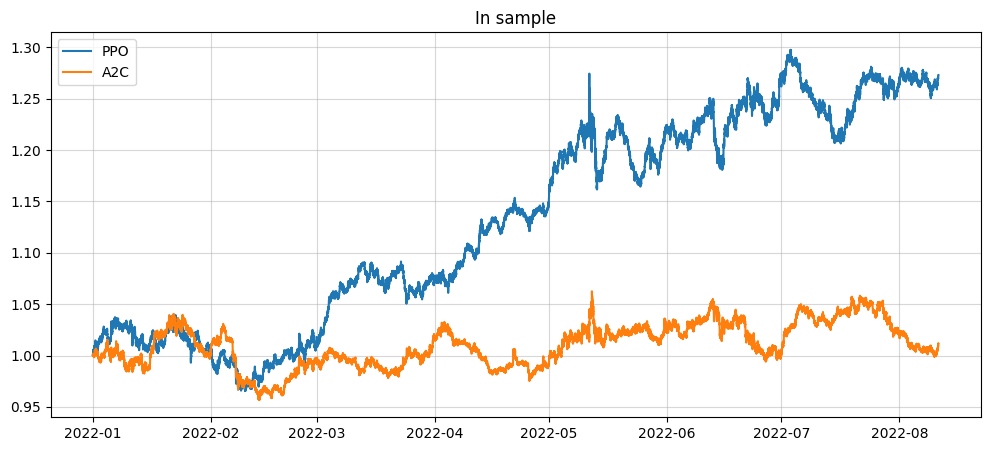

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(timeline[start_idx:val_idx+start_idx], 
        np.array(port_size)/10000, label='PPO')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['A2C']/10000, label='A2C')
# ax.plot(timeline[start_idx:val_idx+start_idx], 
#         btc_benchmark[start_idx:val_idx+start_idx] / btc_benchmark[start_idx], label='BTC')
ax.set_title('In sample')
ax.grid(alpha=0.5)
ax.legend();

#### PPO - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = ppo_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

In [ ]:
df_val['PPO'] = val_port_size

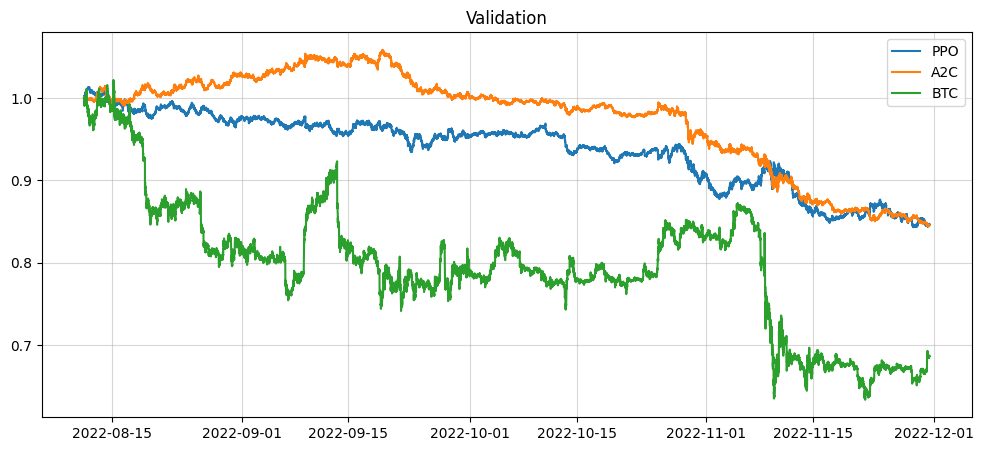

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        np.array(val_port_size)/10000, label='PPO')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['A2C']/10000, label='A2C')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        btc_benchmark[val_idx+start_idx:test_idx+start_idx] / btc_benchmark[val_idx+start_idx], label='BTC')
ax.set_title('Validation')
ax.grid(alpha=0.5)
ax.legend();

## DDPG

#### DDPG - train

In [ ]:
ls_train_gym = LongShortEnv(full_data = train_data)

In [ ]:
ddpg_model = DDPG("MlpPolicy", ls_train_gym, verbose=0, gamma=0.1)
ddpg_model.learn(total_timesteps=300000)
ddpg_model.save(model_dir + "DDPG_lowGamma_v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Episode: 0 | Timesteps: 10000 | Cumulative Return: -0.51%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 1.64%
Episode: 2 | Timesteps: 10000 | Cumulative Return: 3.84%
Episode: 3 | Timesteps: 10000 | Cumulative Return: 2.17%
Episode: 4 | Timesteps: 10000 | Cumulative Return: 2.93%
Episode: 5 | Timesteps: 10000 | Cumulative Return: 1.12%
Episode: 6 | Timesteps: 10000 | Cumulative Return: 4.84%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -0.97%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -0.42%
Episode: 9 | Timesteps: 10000 | Cumulative Return: 2.05%
Episode: 10 | Timesteps: 10000 | Cumulative Return: 0.54%
Episode: 11 | Timesteps: 10000 | Cumulative Return: 7.20%
Episode: 12 | Timesteps: 10000 | Cumulative Return: 4.23%
Episode: 13 | Timesteps: 10000 | Cumulative Return: 1.63%
Episode: 14 | Timesteps: 10000 | Cumulative Return: 3.11%
Episode: 15 | Timesteps: 10000 | Cumulative Return: 2.68%
Episode: 16 | Timesteps: 10000 | Cumulative Return: -5.83%
Episode: 17 | Timest

#### DDPG - in sample

In [ ]:
# in sample performance
ls_train_gym.mode = 'Val'
ls_train_gym.rand_start_time = False
ls_train_gym.total_time = train_data.shape[0]

obs = ls_train_gym.reset()

for i in range(train_data.shape[0]-1):
    action, _states = ddpg_model.predict(obs)
    obs, rewards, dones, info = ls_train_gym.step(action)
port_size =ls_train_gym.save_asset_memory()
weights = ls_train_gym.save_action_memory()

In [ ]:
df_inSample['DDPG'] = port_size

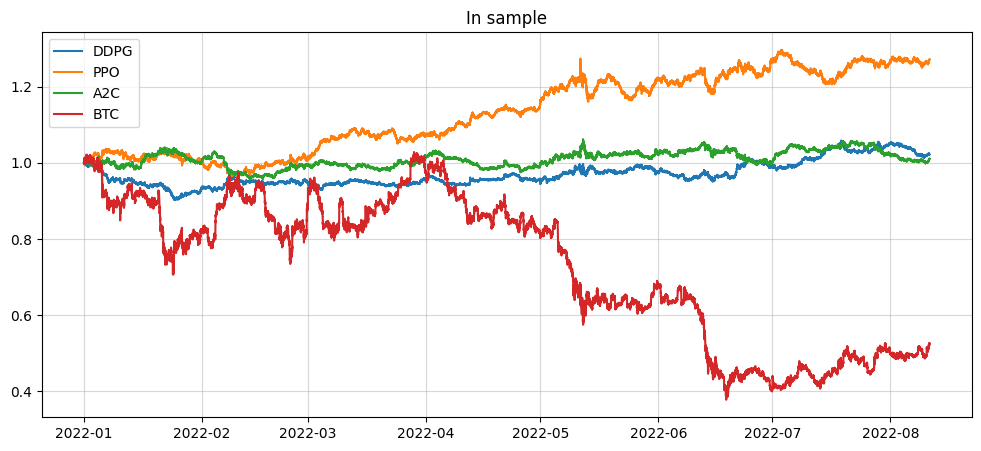

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['DDPG']/10000, label='DDPG')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['PPO']/10000, label='PPO')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        df_inSample['A2C']/10000, label='A2C')
ax.plot(timeline[start_idx:val_idx+start_idx], 
        btc_benchmark[start_idx:val_idx+start_idx] / btc_benchmark[start_idx], label='BTC')
ax.set_title('In sample')
ax.grid(alpha=0.5)
ax.legend();

#### DDPG - Val

In [ ]:
# out of sample performance
ls_val_gym = LongShortEnv(full_data=val_data, total_time=val_data.shape[0], mode='Val', rand_start_time=False)

obs = ls_val_gym.reset()
for i in range(val_data.shape[0]-1):
    action, _states = ddpg_model.predict(obs)
    obs, rewards, dones, info = ls_val_gym.step(action)
val_port_size =ls_val_gym.save_asset_memory()
val_weights = ls_val_gym.save_action_memory()

In [ ]:
df_val['DDPG'] = val_port_size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


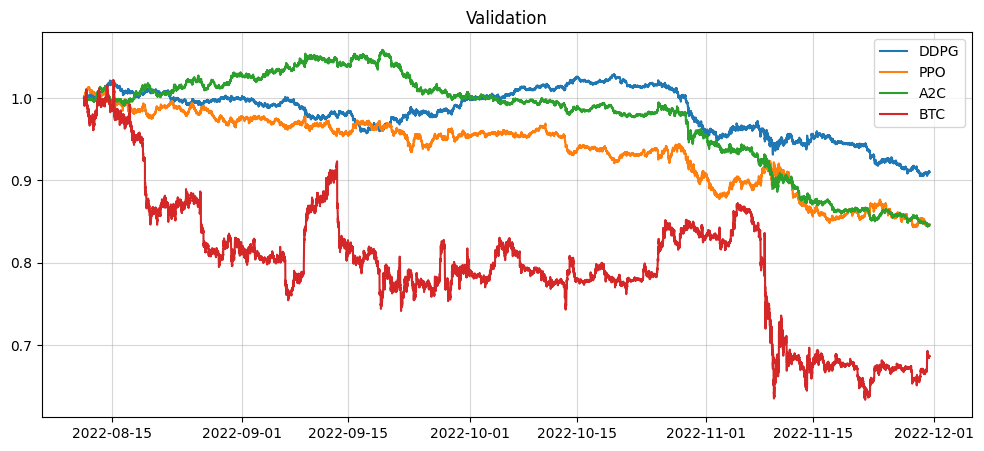

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['DDPG']/10000, label='DDPG')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['PPO']/10000, label='PPO')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        df_val['A2C']/10000, label='A2C')
ax.plot(timeline[val_idx+start_idx:test_idx+start_idx], 
        btc_benchmark[val_idx+start_idx:test_idx+start_idx] / btc_benchmark[val_idx+start_idx], label='BTC')
ax.set_title('Validation')
ax.grid(alpha=0.5)
ax.legend();